In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from preprocess import import_data

sns.set_theme() # ???

In [11]:
df = import_data('../data/train_data.txt')
print(df.shape)
df.head()

(9868, 7)


,id,duration,sex,age,num_children,country,acc_type
0,1010286,7,F,40,0,SE,Apt
1,1000152,5,M,NaN,0,NaN,Apt
2,1009019,4,F,39,1,ES,Hotel
3,1007840,5,F,45,0,NL,Hotel
4,1006939,5,M,45,1,UK,Hotel


In [23]:
# Check last 5 rows
df.tail()

,id,duration,sex,age,num_children,country,acc_type
9863,1002141,2,F,42,0,ES,Apt
9864,1009145,6,M,43,1,DK,Apt
9865,1008594,4,M,39,0,IT,Hotel
9866,1007938,3,M,37,1,IT,Hotel
9867,1000340,3,F,49,1,IT,Apt


In [6]:
# Check for missing values
df.isnull().sum()

id                0
duration          0
sex               0
age             994
num_children    971
country         996
acc_type          0
dtype: int64

In [20]:
# Check what missing values look like to see if they can be retraced
null_data = df[df.isnull().any(axis=1)]
null_data.head(20)
# We see here that NaN in num_children does not mean 0, so real missing values

,id,duration,sex,age,num_children,country,acc_type
1,1000152,5,M,NaN,0,NaN,Apt
9,1006149,5,F,31,NaN,FI,Apt
11,1006502,9,F,44,NaN,ES,Apt
15,1000476,4,F,48,0,NaN,Hotel
16,1011405,3,M,NaN,1,NaN,Hotel
19,1005786,2,F,41,NaN,SE,Hotel
23,1000175,3,M,NaN,1,NaN,Hotel
25,1004610,4,M,43,0,NaN,Apt
27,1004462,8,M,39,NaN,DK,Apt
28,1008547,9,M,NaN,NaN,IT,Hotel


In [24]:
# Check unique values
df.describe()
# For object data (e.g. strings or timestamps),
# the result’s index will include count, unique, top, and freq. The top

,id,duration,sex,age,num_children,country,acc_type
count,9868,9868,9868,8874,8897,8872,9868
unique,9868,13,2,37,2,8,2
top,1010286,4,F,40,1,BE,Hotel
freq,1,2257,4981,714,4488,1161,5592


In [25]:
# As we can see here, all data is object data
df.info()
# However, we want to convert relevant columns into numeric data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9868 entries, 0 to 9867
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            9868 non-null   object
 1   duration      9868 non-null   object
 2   sex           9868 non-null   object
 3   age           8874 non-null   object
 4   num_children  8897 non-null   object
 5   country       8872 non-null   object
 6   acc_type      9868 non-null   object
dtypes: object(7)
memory usage: 539.8+ KB


In [32]:
# Convert the relevant columns into numeric data so df.describe works better
df[["duration", "age", "num_children"]] = df[["duration", "age", "num_children"]].apply(pd.to_numeric)
df.describe()
# Max num_children is 1, this is odd given the amount of data
# But probably this is the case because it is a sample dataset
# We don't see any meaningful outliers here, so no need to remove outliers

,duration,age,num_children
count,9868.000000,8874.000000,8897.000000
mean,4.000507,40.415596,0.504440
std,1.726542,5.037572,0.500008
min,1.000000,22.000000,0.000000
25%,3.000000,37.000000,0.000000
50%,4.000000,40.000000,1.000000
75%,5.000000,44.000000,1.000000
max,13.000000,59.000000,1.000000


In [33]:
df.country.unique() # Seems fine

array(['SE', nan, 'ES', 'NL', 'UK', 'IT', 'FI', 'DK', 'BE'], dtype=object)

In [35]:
# Delete unnecessary variables
df = df.drop(['id'], axis=1)

In [43]:
# This section removes code with more than 40% NA values,
# Already know this is not the case, but for best practice purposes:
NA_val = df.isna().sum()
def na_filter(na, threshold = .4): #only select variables that passees the threshold
    col_pass = []
    for i in na.keys():
        if na[i]/df.shape[0]<threshold:
            col_pass.append(i)
    return col_pass
df = df[na_filter(NA_val)]
df.columns

Index(['duration', 'sex', 'age', 'num_children', 'country', 'acc_type'], dtype='object')

In [47]:
rows_before = df.shape[0]
df = df.dropna(axis=0)
print(f"{df.shape[0] - rows_before} rows deleted when removing rows with missing values")

-2666 rows deleted when removing rows with missing values


<AxesSubplot:>

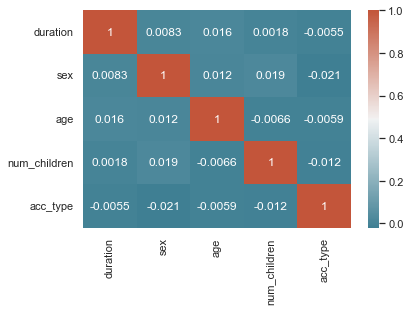

In [51]:
# Prepare df for correlation matrix
df.sex = [1 if sex == 'M' else 0 for sex in df.sex]
df.acc_type = [1 if acc == 'Hotel' else 0 for acc in df.acc_type]
# calculate correlation matrix
corr = df.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
# We see very low correlation numbers

In [53]:
# Function that plots a stacked bar chart for a single variable

def plot_stacked_bar(column):
    plt.figure()
    
    #convert numerical variables for sorted x-axis in plot
    try:
        df[column] = df[column].apply(lambda x: float(x))
        
    except Exception as e:
        print('pass')
        
    
    
    df.groupby(by=column)['acc_type'].value_counts().unstack().plot(kind='bar', stacked=True)
    plt.ylabel('count')
    plt.show()

<Figure size 432x288 with 0 Axes>

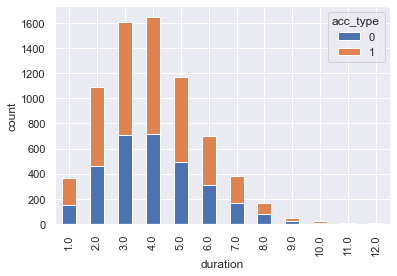

<Figure size 432x288 with 0 Axes>

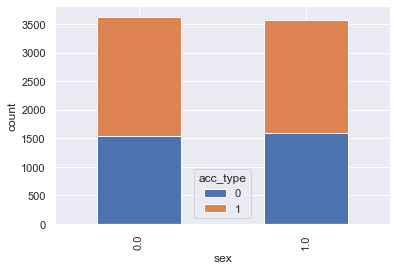

<Figure size 432x288 with 0 Axes>

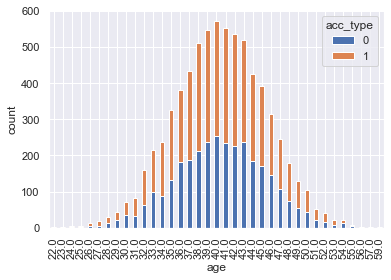

<Figure size 432x288 with 0 Axes>

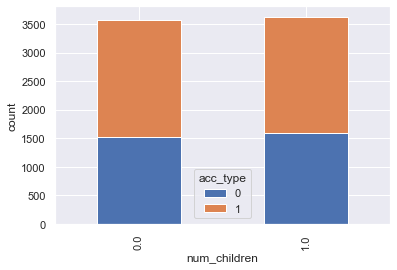

pass


<Figure size 432x288 with 0 Axes>

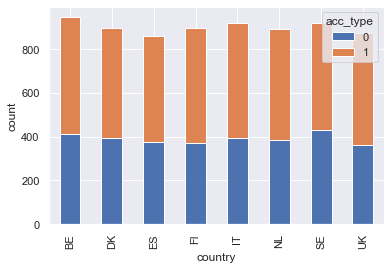

In [54]:
plot_stacked_bar('duration')
plot_stacked_bar('sex')
plot_stacked_bar('age')
plot_stacked_bar('num_children')
plot_stacked_bar('country')